#Classificação de artigos do MediaCloud usando GMM e DPGMM

Neste Notebook vamos aplicar um classificador não supervisionado a uma coleção de artigos extraída do índice do MediaCloud, usando Dirichlet Process Gaussian Mixture models, do Scikit-Learn.
http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm.html#example-mixture-plot-gmm-py

Vamos também explorar técnicas de Deep learning usando word2vec do pacote gensim:
http://radimrehurek.com/gensim/models/word2vec.html

uma explicação mais detalhada da metodologia do word2vec pode ser encontrada aqui:
https://code.google.com/p/word2vec/


In [4]:
import json
import os
import gensim
import pymysql
import nltk # para tokenização de sentenças
from pymongo import MongoClient
from string import punctuation, digits
import bs4
from sklearn import mixture
import datetime
import pandas as pd

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Primeiro vamos definir uma função para busca no índice:

In [6]:
def sphinx_query(index_name, query="", facet=None):
    """
    Search Sphinx index using a simple match via SphinxQL
    :param index_name: Name of the index to search on
    :param query: String with the query expression
    :param facet: Attribute name to facet by. Must be a list
    :return: JSON (array of objects)
    """
    try:
        assert index_name in ['mediacloud_articles', 'mediacloud_feeds', 'mediacloud_tweets']
    except AssertionError:
        return json.dumps({"error": "Bad index name: {}".format(index_name)})
    

    # Setup Sphinxsearch SphinxQL connection
    sphinx_conn = pymysql.connect(host='200.20.164.152', port=9306)
    cursor = sphinx_conn.cursor(pymysql.cursors.DictCursor)

    if facet is None:
        cursor.execute("SELECT * from " + index_name + " WHERE MATCH(%(query)s) "
                "LIMIT %(limit)s OPTION max_matches=%(limit)s",
                    {'query': query, 'limit': 100000})
    else:
        cursor.execute("SELECT * from "+index_name+" WHERE MATCH(%s) " + " ".join(["FACET {}".format(f) for f in facet]),
                       (query,))
    results = cursor.fetchall()
    cursor.close()
    
    return json.dumps(results)


In [8]:
consulta = 'Marina silva'
res = sphinx_query("mediacloud_articles",'"{}" '.format(consulta))
res = json.loads(res)
# retemos apenas as entradas que contém sumários
#filtramos também por datas
data_ini = datetime.datetime(2014,8,10,0,0,0)
data_fim = datetime.datetime(2014,8,28,0,0,0)
res = [d for d in res if  datetime.datetime.fromtimestamp(d['published'])> data_ini and datetime.datetime.fromtimestamp(d['published']) <= data_fim]
print("{} resultados retidos".format(len(res)))

2467 resultados retidos


In [9]:
res[:3]

[{'id': 944080,
  'summary': '<div class="field content-taxonomy field-categoria-noticia">\n                                <h3 class="label inline">Categoria:&nbsp;</h3>\n          <div class="item inline odd">Eleições</div>\n         <h5 class="description"></h5>\n              </div>\n <!-- /content-field -->\n <!-- /content-field -->\n <!-- /content-field -->\n<p><img alt="" src="http://og.infg.com.br/in/12757943-f0f-c71/FT1086A/420/GetContentCA9VS5MB.jpg" style="width: 500px; height: 300px;" /></p>\n<p><strong>Jornal GGN </strong>- Sai na próxima semana a decisão sobre quem o PSB lançará como candidato a presidente no lugar de Eduardo Campos, morto em acidente aéreo no último dia 13. Marina Silva é a favorita pelo recall que tem junto ao eleitorado desde a eleição de 2010.</p>\n<p>Mas Marina, desde que ingressou no PSB, deixou claro que esse arranjo é provisório. Dura até que a Rede Sustentabilidade saia do papel. Diante do impasse sobre o futuro da chapa em 2014, fica a pergunta:

Exportando a série Temporal

/usr/lib/python3/dist-packages/IPython/kernel/__main__.py:1: FutureWarning: TimeSeries is deprecated. Please use Series
  if __name__ == '__main__':


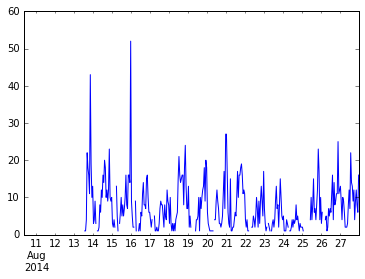

In [10]:
ts = pd.TimeSeries(data=np.ones(len(res)),index=[datetime.datetime.fromtimestamp(d['published']) for d in res])
#ts['Count']=1
rts=ts.resample('h',how="sum")
rts.plot();
#rts.to_csv('{}+filha;filho;renata;miguel_porhora_noticias.csv'.format(consulta))

Vamos agora construir um corpus só com os sumários

In [11]:
docs = [bs4.BeautifulSoup(d['summary']).get_text() for d in res]

/usr/lib/python3/dist-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


Antes de poder aplicar o word2vec, precisamos criar um banco de frases que são a matéria prima do word2vec. Vamos armazenar estas frases em um banco Mongodb para facilitar a iteração sobre as frases.

Cada Documento dividido em frases se converte na seguinte lista:

In [8]:
nltk.tokenize.sent_tokenize(docs[1])

[u'  E AGORA MARINA SILVA ?',
 u'VICE NA CHAPA DE GERALDO ALCKMIN DIZ QUE \xc9 MARINA QUEM PRECISA DO PSB"ELA N\xc3O PARTICIPA DE NADA NEM SABE O PRE\xc7O DO ALUGUEL DE UM COMIT\xca ELEITORAL" - M\xe1rcio Fran\xe7a / PSB-SPO PSB de S\xe3o Paulo n\xe3o parece muito interessado na quest\xe3o nacional  do Partido, que tem de substituir Eduardo Campos, falecido em tr\xe1gico  acidente de avi\xe3o ocorrido na \xfaltima Quarta-Feira.',
 u"Marina Silva, ao que  tudo indica, ser\xe1 a nova cabe\xe7a de chapa do partido socialista, mas, as  resist\xeancias ao seu nome, e principalmente as condi\xe7\xf5es que j\xe1 est\xe3o  sendo colocadas na mesa de negocia\xe7\xe3o para \xa0que ela assuma a  candidatura, est\xe3o crescendo na medida em que o tempo passa, e os  interesses eleitorais se sobrep\xf5e ao impacto do acidente e perplexidade  perante a perda do ex-governador e at\xe9 ent\xe3o candidato \xe0 presid\xeancia,  Eduardo Campos.Coube ao membro do PSB de S\xe3o Paulo, que \xe9 o candidato a

In [7]:
#criando um banco com as frases:
client = MongoClient()
db = client.word2vec
db.drop_collection('frases')

frases = db.frases
for n,doc in enumerate(docs):
    frases.insert({'doc': n, 'frases':nltk.tokenize.sent_tokenize(doc)})


Agora vamos escrever um gerador que retorne uma frase de cada vez, como uma lista de tokens. mas antes vamos reduzir as palavras para minúsculas.

In [8]:
sw = nltk.corpus.stopwords.words('portuguese') + list(punctuation) + ['r',u'não',u'é', u'à','quarta','feira', 
                                                          u'até', u'já', ')','(','"','\'','...', 
                                                          'nesta', 'leia','quinta', 'foto',u'terça',
                                                          'dub','diz','dia',u'está','sexta', u'\u2022', '']
def get_sentences():
    for doc in frases.find({}):
        for f in doc['frases']:
            yield [w.strip().strip(punctuation).strip(digits).lower() for w in f.split() if w not in sw]
        

In [9]:
sentences = get_sentences()
model = gensim.models.Word2Vec(sentences, min_count=15, size=5000, workers=8)

-c:8: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [39]:
model[u'campos']

array([  5.23893279e-04,   1.79088038e-05,   1.05028019e-04,
         2.29172118e-04,   2.95586302e-04,   7.58165203e-04,
        -5.76344319e-04,   2.38053588e-04,   5.28062810e-05,
         1.92863081e-04,   5.85806207e-04,   7.97907705e-04,
         9.24295513e-04,   8.21865979e-04,  -9.21872561e-04,
        -9.73194081e-04,   2.61064735e-04,  -7.43841345e-04,
         3.51673807e-04,  -3.75185453e-04,   8.89859628e-04,
         6.00494270e-04,   6.72011229e-05,  -1.55870031e-04,
        -1.72735075e-04,   4.95197164e-05,  -6.47866807e-04,
         9.84237646e-04,  -6.03786204e-04,  -8.39359200e-05,
         2.75766390e-04,  -1.89963670e-04,  -5.39175526e-04,
         5.62078203e-04,   1.19242177e-04,   2.42233567e-04,
         7.56517285e-04,  -6.19249622e-05,   2.87531933e-04,
        -9.46478627e-04,  -1.06012034e-04,  -5.92135708e-04,
        -3.77774268e-04,   2.74946186e-04,   3.78991885e-04,
         1.86964171e-04,  -7.96205422e-04,  -3.42984742e-04,
         4.47301900e-05,

In [10]:
model.most_similar(positive=[u'eduardo', u'marina' ], negative=[u'aécio'], topn=10)

[(u'pr\xf3xima', 0.0489029735326767),
 (u'judici\xe1rio', 0.04631877690553665),
 (u'nara', 0.04554399847984314),
 (u'psol', 0.04423150420188904),
 (u'voltar', 0.04336097091436386),
 (u'coletiva', 0.04289194196462631),
 (u'provocou', 0.0422094501554966),
 (u'ter\xe7a', 0.041922423988580704),
 (u'eleitorado', 0.04177185148000717),
 (u'tend\xeancia', 0.04028308391571045)]

In [11]:
model.doesnt_match(['eduardo', 'marina', 'psb', 'avião', 'futebol'])

'eduardo'

In [12]:
model.similarity('marina','psb')

0.016895555188071957

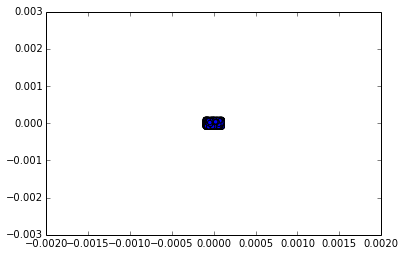

In [13]:
scatter(model.syn0[:,1],model.syn0[:,2]);

In [14]:
len(model.vocab)

3779

In [30]:
model.table

In [16]:
model.vocab

{u'': <gensim.models.word2vec.Vocab at 0x7fa07c337310>,
 u')foto': <gensim.models.word2vec.Vocab at 0x7fa07c3ee0d0>,
 u',': <gensim.models.word2vec.Vocab at 0x7fa07c339590>,
 u'-': <gensim.models.word2vec.Vocab at 0x7fa07c3d56d0>,
 u'.': <gensim.models.word2vec.Vocab at 0x7fa07c82b050>,
 u'/': <gensim.models.word2vec.Vocab at 0x7fa07c320310>,
 u'/02/2013)foto': <gensim.models.word2vec.Vocab at 0x7fa07c361e90>,
 u'/07)foto': <gensim.models.word2vec.Vocab at 0x7fa07c3f0950>,
 u'/08).foto': <gensim.models.word2vec.Vocab at 0x7fa07b749b50>,
 u'/08)foto': <gensim.models.word2vec.Vocab at 0x7fa07c361790>,
 u'/08/': <gensim.models.word2vec.Vocab at 0x7fa07d762750>,
 u'/1/2014)foto': <gensim.models.word2vec.Vocab at 0x7fa07c3d5110>,
 u'/10/2010)foto': <gensim.models.word2vec.Vocab at 0x7fa07c361650>,
 u'/15/': <gensim.models.word2vec.Vocab at 0x7fa07c35ed10>,
 u'/16/': <gensim.models.word2vec.Vocab at 0x7fa07c829150>,
 u'/21/': <gensim.models.word2vec.Vocab at 0x7fa07c81fa90>,
 u'/6)foto': <ge

##Criando Clusters de palavras usando o DPGMM

In [23]:
dpgmm = mixture.DPGMM(n_components=10,n_iter=5, covariance_type='diag')
dpgmm.fit(model.syn0)

DPGMM(alpha=1.0, covariance_type='diag', init_params='wmc', min_covar=None,
   n_components=10, n_iter=5, params='wmc',
   random_state=<mtrand.RandomState object at 0x7fa0bae71af8>, thresh=0.01,
   verbose=False)

In [24]:
dpgmm.converged_

False

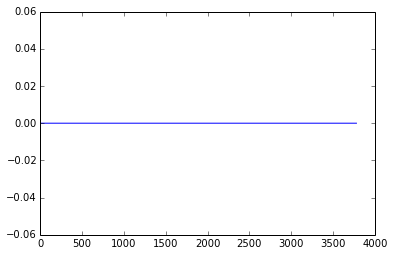

In [25]:
plot(dpgmm.predict(model.syn0));

(10, 5000)


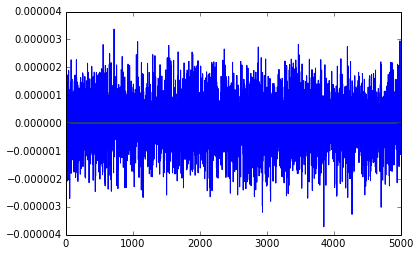

In [26]:
print dpgmm.means_.shape
plot(dpgmm.means_.T);

## Agora com o GMM

In [27]:
gmm = mixture.GMM(n_components=3, covariance_type='diag')
gmm.fit(model.syn0)

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=3, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=0.01)

(3, 5000)


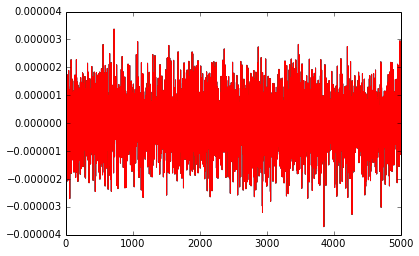

In [28]:
print gmm.means_.shape
plot(gmm.means_.T);

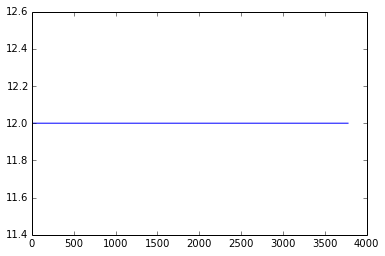

In [21]:
plot(gmm.predict(model.syn0));

In [22]:
gmm.converged_

True

In [18]:
mixture.GMM?

## Usando o SKlearn para extração de Features

In [37]:
from __future__ import print_function

from pprint import pprint
from time import time
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans, MiniBatchKMeans


In [67]:
t0 = time()
hasher = HashingVectorizer(n_features=10000,
                                   stop_words=sw, non_negative=True,
                                   norm=None, binary=False)
vectorizer = make_pipeline(hasher, TfidfTransformer())

X = vectorizer.fit_transform(docs)
print("done in %fs" % (time() - t0))
print("n_samples: %d, n_features: %d" % X.shape)
print()

done in 29.694485s
n_samples: 6615, n_features: 10000



In [77]:
n_clusters = 3
dpgmm = mixture.DPGMM(covariance_type='diag')
km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1,
                verbose=True, n_jobs=8)
#dpgmm.fit(X)

In [78]:
labels = range(X.shape[0]-1)
print("Clustering sparse data with %s" % km)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))
print()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]


Clustering sparse data with KMeans(copy_x=True, init='k-means++', max_iter=100, n_clusters=3, n_init=1,
    n_jobs=8, precompute_distances=True, random_state=None, tol=0.0001,
    verbose=True)
done in 0.395s

Top terms per cluster:
Initialization complete
Iteration  0, inertia 5680.000
Iteration  1, inertia 5610.934
Converged at iteration 1


In [91]:
k_means_labels = km.labels_
k_means_cluster_centers = km.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
# KMeans
colors = ['#4EACC5', '#FF9C34', '#4E9A06']
for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    #plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col, markeredgecolor='k', markersize=6)
title('KMeans')
#set_xticks(())
#set_yticks(())
pylab.text(-3.5, 1.8,  'inertia: %f' % (km.inertia_));

In [45]:
mixture.DPGMM?

In [47]:
X.shape

(6615, 10000)

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)